# Searching the EOPF Sentinel Zarr Samples Service STAC API

## Introduction

In this tutorial, we will explore how to access Sentinel-1, Sentinel-2, and Sentinel-3 `.zarr` collections available through the [EOPF Sentinel Zarr Sample Service STAC](https://stac.browser.user.eopf.eodc.eu/?.language=en). <br>
This powerful API provides a structured way to search and access EOPF data using Python.

#### Prerequisites

The `pystac` and `pystac_client` libraries are essential for requesting and conducting deep searches within the STAC environment, enabling efficient data processing. We encourage you to consult the [pystac documentation](https://pystac.readthedocs.io/en/stable/) and [pystac_client documentation](https://pystac-client.readthedocs.io/en/latest/api.html) for additional resources and in-depth information.

> **Note:** <br>
> We recommend creating a virtual environment as it helps manage library versions and prevents conflicts with other Python projects on your system. <br>
> Follow [this tutorial](), to create a virtual environment that will allow us to run all the available tutorials in [EOPF-101](https://github.com/eopf-toolkit/eopf-101). 


<hr>


##### Import libraries
To ensure a stable and reproducible environment for our project, we begin by setting up our dependencies.

In [1]:
import requests
from typing import List, Optional, cast
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
from datetime import datetime

##### Helper functions

##### `list_found_elements`


As we anticipate visualising several elements stored in lists, we will define a helper function to streamline id's retrieval inside our workflow.

In [ ]:
def list_found_elements(search_result):
    id = []
    coll = []
    for item in search_result.items(): #retrieves the result inside the catalogue.
        id.append(item.id)    # stores item (image) id
        coll.append(item.collection_id)  #stores the collections id
    return id , coll

<hr>

## API connection

Our first step is to construct our request to interact with the EOPF STAC API. This involves defining the parameters for the data we wish to retrieve.<br>
The API's base URL is conveniently available through the [OpenAPI service description](https://stac.core.eopf.eodc.eu), which can be found in the **Additional Resources** tab of the [EOPF Sentinel Zarr Sample Service STAC API](https://stac.browser.user.eopf.eodc.eu/?.language=en).

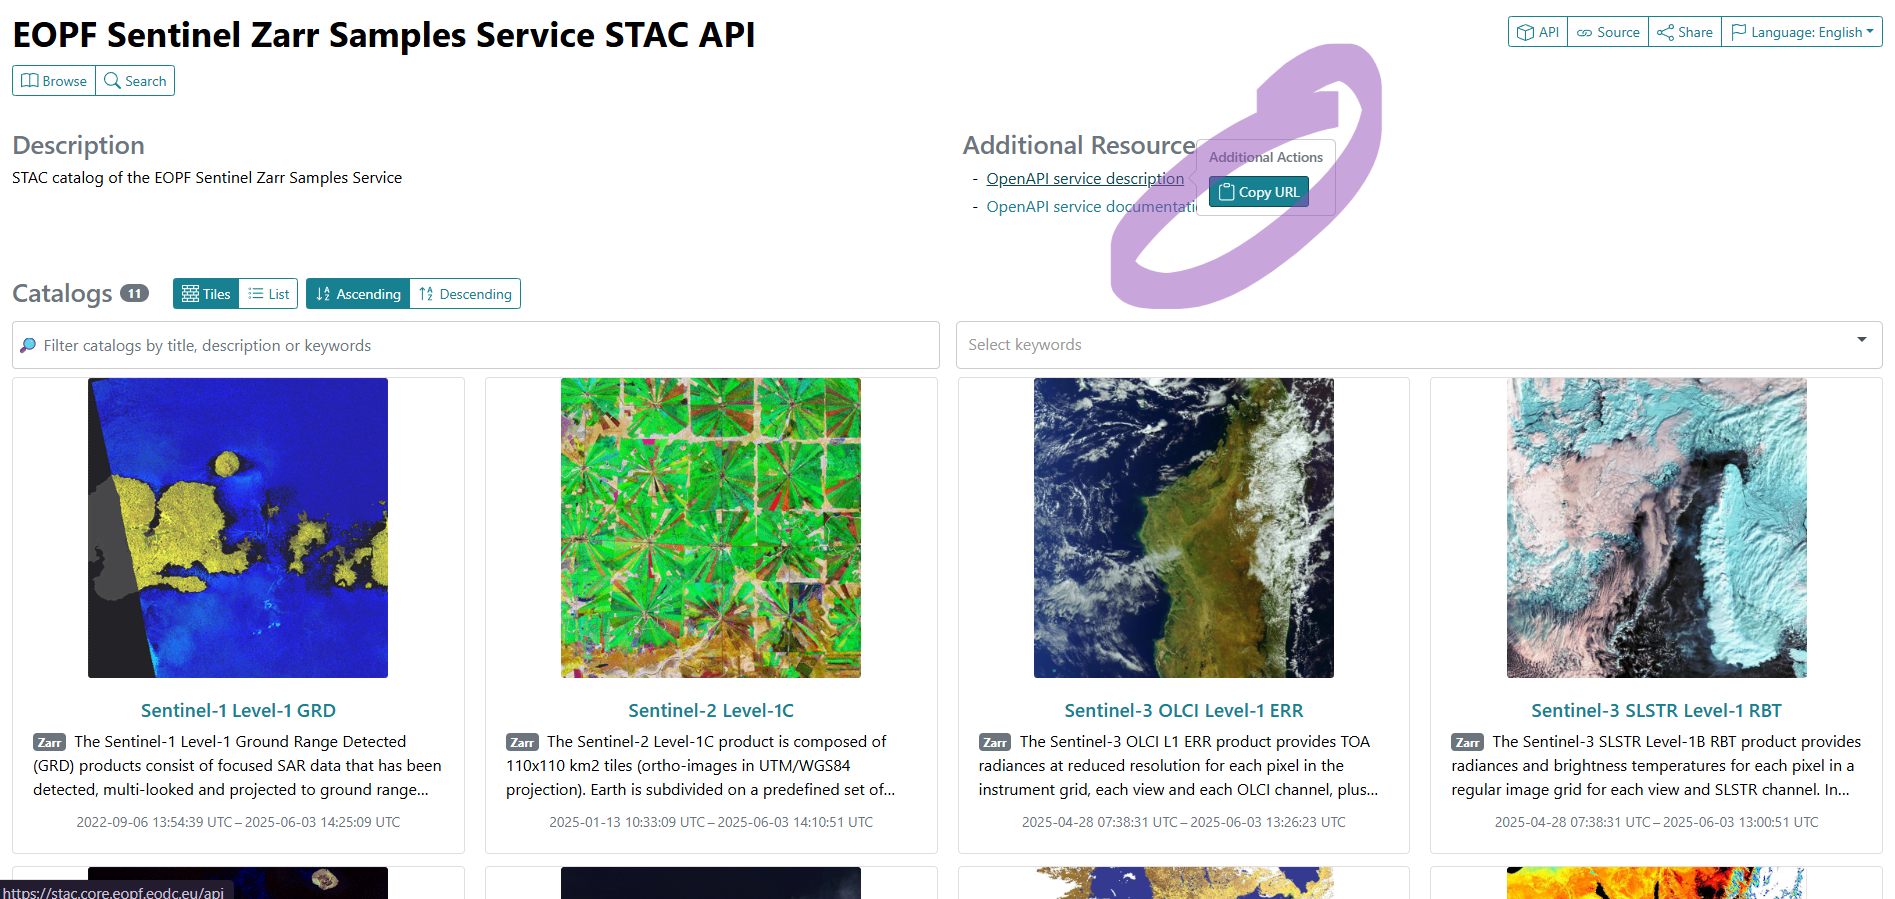

This entry, provides the starting point of the Catalogue.

In [3]:
max_description_length = 100

eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
client = Client.open(url=eopf_stac_api_root_endpoint)

Rectifying the catalog we have just accessed:

In [4]:
print(
    "Connected to Catalog {id}: {description}".format(
        id=client.id,
        description=client.description
        if len(client.description) <= max_description_length
        else client.description[: max_description_length - 3] + "...",
    )
)

Connected to Catalog eopf-sample-service-stac-api: STAC catalog of the EOPF Sentinel Zarr Samples Service


It is important to remember that the Sentinel Zarr Sample Service STAC **is actively under development** and receives continuous updates and additions to its collections. To ensure we access only currently available resources, we include a verification step to confirm data availability within the catalogue.<br> This proactive approach helps us understand what data is presently accessible.

> **Note:** <br>
> To explore further issues or more considerations check un the [EOPF Sentinel Zarr Samples Service](https://zarr.eopf.copernicus.eu/) updates and their [Github Issues](https://github.com/EOPF-Sample-Service/eopf-stac/issues)

In [5]:
all_collections: Optional[List[Collection]] = None
# The simplest approach to retrieve all collections may fail due to #18 on Github.

try:
    all_collections = [_ for _ in client.get_all_collections()]
    print(
        "* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 appears to be resolved]"
    )
except Exception:
    print(
        "* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 appears to not be resolved]"
    )


* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 appears to not be resolved]


We observe that one collection is currently undergoing updates, and a refinement of our search to work exclusively with available resources is needed.

## Available Collections

We can filter the available Collections to have an overview of the instances we can retrieve:

In [6]:
if all_collections is None:
    # If collection retrieval fails due to #18.
    valid_collections: List[Collection] = []
    for collection_href in [link.absolute_href for link in client.get_child_links()]:
        collection_dict = requests.get(url=collection_href).json()
        try:
            # Attempt to retrieve collections individually.
            valid_collections.append(Collection.from_dict(collection_dict))
        except Exception as e:
            if isinstance(e, TypeError) and "not subscriptable" in str(e).lower():
                # This exception is expected for some collections due to #18.
                continue
            else:
                raise e
            
    all_collections = valid_collections


And the available collections that can be explored are:

In [7]:
print(all_collections)

[<Collection id=sentinel-2-l2a>, <Collection id=sentinel-3-slstr-l1-rbt>, <Collection id=sentinel-3-olci-l2-lfr>, <Collection id=sentinel-2-l1c>, <Collection id=sentinel-3-slstr-l2-lst>, <Collection id=sentinel-1-l1-slc>, <Collection id=sentinel-3-olci-l1-efr>, <Collection id=sentinel-3-olci-l1-err>, <Collection id=sentinel-1-l2-ocn>, <Collection id=sentinel-1-l1-grd>]


After performing an initial check, we can see the collections, their temporal extent and a description where we can successfully retrieve `zarr` encoded items.

In [8]:
for collection in all_collections:
    collection_parent = collection.get_parent()
    start_date = collection.extent.temporal.intervals[0][0] # Get the first available date of the items
    end_date = collection.extent.temporal.intervals[0][1]   # Get the last available date of the items
    print("Collection {id}".format(id=collection.id))  # Collection id
    print(
        " - Description: {description}".format(        # Summary of the contained information
            description=collection.description
            if len(collection.description) <= max_description_length
            else collection.description[: max_description_length - 3] + "..."
        )
    )
    print(
        " - Temporal Extent: {start_date} to {end_date}".format(
        start_date = start_date.strftime("%Y-%m-%d"),
        end_date = end_date.strftime("%Y-%m-%d")
        )
    )
    

Collection sentinel-2-l2a
 - Description: The Sentinel-2 Level-2A Collection 1 product provides orthorectified Surface Reflectance (Bottom-...
 - Temporal Extent: 2018-06-01 to 2025-06-04
Collection sentinel-3-slstr-l1-rbt
 - Description: The Sentinel-3 SLSTR Level-1B RBT product provides radiances and brightness temperatures for each...
 - Temporal Extent: 2025-04-28 to 2025-06-05
Collection sentinel-3-olci-l2-lfr
 - Description: The Sentinel-3 OLCI L2 LFR product provides land and atmospheric geophysical parameters computed ...
 - Temporal Extent: 2025-04-28 to 2025-06-04
Collection sentinel-2-l1c
 - Description: The Sentinel-2 Level-1C product is composed of 110x110 km2 tiles (ortho-images in UTM/WGS84 proje...
 - Temporal Extent: 2025-01-13 to 2025-06-04
Collection sentinel-3-slstr-l2-lst
 - Description: The Sentinel-3 SLSTR Level-2 LST product provides land surface temperature.
 - Temporal Extent: 2025-04-28 to 2025-06-05
Collection sentinel-1-l1-slc
 - Description: The Sentinel-1

## EOPF Sentinel Zarr Samples Service STAC API Browse

With the `.search()` argument inside our `client` definition, we are able to define a series of parameters that allow us filtering the available data that match the criteria we are interested in.

### Bounding Box
To narrow down our data search, we can define a specific area of interest. We are able to do this by providing a bounding box (`bbox`), which is composed by a tuple which contains the top-left and bottom-right corner coordinates.<br>

For example, we can focus our search on the outskirts of Innsbruck, Austria.

In [9]:
bbox_search = client.search(
    bbox=(
        11.124756, 47.311058, #top left
        11.459839, 47.463624  #bottom-right
        )
)

In [10]:
innsbruck_sets=list_found_elements(bbox_search) #we apply our constructed function
print('Available Collections: ',set(innsbruck_sets[1]))
print('Retrieved Items: ',len(innsbruck_sets[0]))

Available Collections:  {'sentinel-2-l2a', 'sentinel-3-olci-l1-efr', 'sentinel-1-l1-slc', 'sentinel-3-olci-l1-err', 'sentinel-3-olci-l2-lfr', 'sentinel-1-l1-grd', 'sentinel-2-l1c', 'sentinel-3-slstr-l2-lst', 'sentinel-3-slstr-l1-rbt'}
Retrieved Items:  197


Based on our search within the defined area of interest (until the most updated version of the tutorial), we can see that out of the initial 11 collections, 9 collections have available data, containing a total of 197 `zarr` items, intersecting the defined coordinates.<br>
This gives us a clear picture of the data density in our Area of Interest (AOI).

### Time frame

Filtering data by a specific time interval is also incredibly useful. The `datetime` parameter allows us to focus on imagery captured within a particular period.<br>
Let's define an interval that spans, for example, between May 1, 2020, and May 31, 2023.

In [11]:
time_frame = client.search(
    datetime="2020-05-01T00:00:00Z/2023-05-31T23:59:59.999999Z")


Then, the available collections and number of assets contained are:

In [12]:
time_items=list_found_elements(time_frame) #we apply our constructed function
print('Available Collections: ',set(time_items[1]))
print('Retrieved Items: ',len(time_items[0]))

Available Collections:  {'sentinel-1-l1-grd', 'sentinel-2-l2a'}
Retrieved Items:  270


### Combined Search

Now, we can explore how to refine our search even further by combining multiple criteria. <br>
This capability is incredibly powerful for pinpointing precisely the data we need. For instance, we can search for items within a specific time frame and from a particular collection simultaneously.<br>
We will focus our attention on the Sentinel-2 L2A Collection.

We define the `collections` argument by the collection `id` argument inside the Catalogue:

In [13]:
sentinel2 = client.search(
    collections= ['sentinel-2-l2a'], # the collection we are interesed in
    datetime="2020-05-01T00:00:00Z/2023-05-31T23:59:59.999999Z" # the time frame of interest
)


We can then observe that the entire Sentinel-2 L2A collection, up to our selected timeframe, comprises:

In [14]:
multiple_items=list_found_elements(sentinel2) #we apply our constructed function
print('Retrieved Items between 01-May-2020 and 31-May-2023: ',len(multiple_items[0]))

Retrieved Items between 01-May-2020 and 31-May-2023:  196


A common workflow in Earth Observation (EO) analysis involves retrieving datasets within a defined AOI and a specific time frame.<br>
`pystac` allows us to combine these three arguments seamlessly during our search.

In [15]:
innsbruck_s2 = client.search(
    bbox=(11.124756, 47.311058, # AOI extent
          11.459839,47.463624),
    collections= ['sentinel-2-l2a'], # interest Collection
    datetime='2020-05-01T00:00:00Z/2025-05-31T23:59:59.999999Z' # interest period
)

So, for Innsbruck outskirts area, we have:

In [16]:
new_ins=list_found_elements(innsbruck_s2)
print('Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Innsbruck, Austria: ',len(new_ins[0]))

Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Innsbruck, Austria:  27


And we can do the same with another location. <br>

We set a new AOI as the Sea Area of Rostock, Germany with the `bbox`:

In [17]:
rostock_s2 = client.search(
    bbox=(11.766357,53.994566, # AOI extent
          12.332153,54.265086),
    collections= ['sentinel-2-l2a'], # interest Collection
    datetime='2020-05-01T00:00:00Z/2025-05-31T23:59:59.999999Z' # interest period
)

new_ins=list_found_elements(rostock_s2)
print('Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Rostock, Germany: ',len(new_ins[0]))

Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Rostock, Germany:  124


### Location in Catalogue

Thus far, we have conducted a search within the STAC catalogue and browsed the general metadata of the collections. To access the actual `zarr` items themselves, we need to locate the object that allows us to explore their cloud storage location.<br>
Such an element can be found within the `.self_href` attribute when retrieving the selected items (searched through `client.search()`). <br>

Defining our search again in Innsbruck:

In [18]:
new_ins=list_found_elements(innsbruck_s2)
print('Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Innsbruck, Austria: ',len(new_ins[0]))

Retrieved Sentinel 2 L2A Items between 01-May-2020 and 31-May-2025 close to Innsbruck, Austria:  27


In [19]:
c_sentinel2 = client.get_collection('sentinel-2-l2a')
c_sentinel2_urls=[]
for x in range(len(new_ins[0])):
    c_sentinel2_urls.append(c_sentinel2.get_item(new_ins[0][x]).self_href) # call out, the defined search at Innsbruck, Austria.

We are able to retrieve the location of the metadata `.json` extension, which contains the individual parameters for each asset of the item. <br>
This information will allow us to obtain the items' metadata, such as the `hrefs` (the cloud storage path) for accessing each of the assets that comprise the `.zarr` item or group of items of our interest.


In [ ]:
c_sentinel2_urls[:4]

['https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2A_MSIL2A_20250527T102041_N0511_R065_T32TPT_20250527T165916',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2B_MSIL2A_20250527T100559_N0511_R022_T32TPT_20250527T155229',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2C_MSIL2A_20250525T101621_N0511_R065_T32TPT_20250525T153015',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2A_MSIL2A_20250524T100701_N0511_R022_T32TPT_20250524T121311',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2C_MSIL2A_20250522T100611_N0511_R022_T32TPT_20250522T153214',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2A_MSIL2A_20250517T101701_N0511_R065_T32TPT_20250517T120915',
 'https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2B_MSIL2A_20250517T100559_N051

## Now it is your turn

1. Go to [http://bboxfinder.com/](http://bboxfinder.com/) and select an area of interest.<br>

2. Select the items over 2022, 2023 and 2024. How many items for the Catalogue are available for each year?<br>

3. Select a Sentinel Mission and search again. How many items are available for the selected mission?<br>


<hr>

## Conclusion

This tutorial has provided a clear and practical introduction to exploring the [EOPF Sentinel Zarr Sample Service STAC API](https://stac.browser.user.eopf.eodc.eu/?.language=en).<br>
We were able to explore how to connect to the EOPF available API, navigate its structure, and filter data by spatial and temporal criteria though Python. <br>

By leveraging the `pystac` and `pystac_client` libraries, we have the tools to efficiently search for and access the vast amounts of Earth Observation data available through this powerful catalog. <br>
This understanding forms a solid foundation for further analysis and application of Sentinel data in your projects.

#### What's next?

In the following tutorial, we will explore how to retrieve an Item of our interest, based on several parameters and load it through `xarray`.<br>

This will allow us to seamlessly work with the multi-dimensional array data stored insude `zarr`, opening a new workflow for analysis and visualisation of the EOPF for the Copernicus Sentinel 1, Sentinel 2 and Sentinel 3 missions.